# Assignment 04 LSTM Time Series Los Angeles with 5 Epochs

In [1]:
# Data Analysis Libraries
import numpy 
import pandas 
import math

# Data Visualization
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Deep Learning Libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Assessment Libraries
from sklearn.metrics import mean_squared_error

In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [3]:
dataframe = pandas.read_csv('/content/sample_data/la.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LXXRSA  420 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

294 126


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
# create and fit the LSTM network
%%time
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
292/292 - 2s - loss: 0.0280 - 2s/epoch - 7ms/step
Epoch 2/5
292/292 - 0s - loss: 0.0136 - 422ms/epoch - 1ms/step
Epoch 3/5
292/292 - 0s - loss: 0.0066 - 417ms/epoch - 1ms/step
Epoch 4/5
292/292 - 0s - loss: 0.0019 - 404ms/epoch - 1ms/step
Epoch 5/5
292/292 - 0s - loss: 3.2273e-04 - 413ms/epoch - 1ms/step
CPU times: user 5.26 s, sys: 1.06 s, total: 6.31 s
Wall time: 4.12 s


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


R-Squared: 0.974086


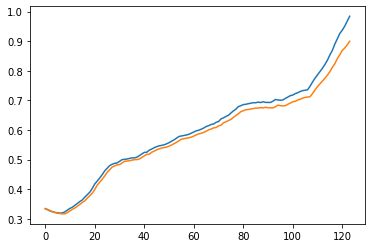

In [12]:
from sklearn.metrics import r2_score

y_pred = model.predict(testX)
plt.plot(testY)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(testY, y_pred)))

In [13]:
mape = tf.keras.losses.MeanAbsolutePercentageError()
mape(testY, y_pred).numpy()


32.35602

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [15]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [16]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.26 RMSE
Test Score: 8.35 RMSE


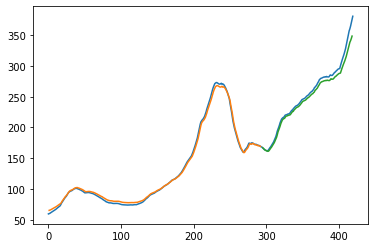

In [17]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### The above graph overlays the Train and Test Predictions